<a href="https://colab.research.google.com/github/kauecapellato/artigo_ic/blob/main/football_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing the data

In [1]:
!pip install selenium

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from seaborn import heatmap
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path = "/content/gdrive/MyDrive/games_epl/"
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

playing_statistics_1 = pd.read_csv(path + 'E0.csv', usecols = columns_req, nrows = 381)
playing_statistics_2 = pd.read_csv(path + 'E0 (1).csv', usecols = columns_req, nrows = 381)
playing_statistics_3 = pd.read_csv(path + 'E0 (2).csv', usecols = columns_req, nrows = 381)
playing_statistics_4 = pd.read_csv(path + 'E0 (3).csv', usecols = columns_req, nrows = 381)
playing_statistics_5 = pd.read_csv(path + 'E0 (4).csv', usecols = columns_req, nrows = 381)
playing_statistics_6 = pd.read_csv(path + 'E0 (5).csv', usecols = columns_req, nrows = 381)
playing_statistics_7 = pd.read_csv(path + 'E0 (6).csv', usecols = columns_req, nrows = 381)
playing_statistics_8 = pd.read_csv(path + 'E0 (7).csv', usecols = columns_req, nrows = 381)
playing_statistics_9 = pd.read_csv(path + 'E0 (8).csv', usecols = columns_req, nrows = 381)
playing_statistics_10 = pd.read_csv(path + 'E0 (9).csv', usecols = columns_req, nrows = 381)
playing_statistics_11 = pd.read_csv(path + 'E0 (10).csv', usecols = columns_req, nrows = 381)
playing_statistics_12 = pd.read_csv(path + 'E0 (11).csv', usecols = columns_req, nrows = 381)
playing_statistics_13 = pd.read_csv(path + 'E0 (12).csv', usecols = columns_req, nrows = 381)
playing_statistics_14 = pd.read_csv(path + 'E0 (13).csv', usecols = columns_req, nrows = 381)
playing_statistics_15 = pd.read_csv(path + 'E0 (14).csv', usecols = columns_req, nrows = 381)
playing_statistics_16 = pd.read_csv(path + 'E0 (15).csv', usecols = columns_req, nrows = 381)
playing_statistics_17 = pd.read_csv(path + 'E0 (16).csv', usecols = columns_req, nrows = 381)
playing_statistics_18 = pd.read_csv(path + 'E0 (17).csv', usecols = columns_req, nrows = 381)
playing_statistics_19 = pd.read_csv(path + 'E0 (18).csv', usecols = columns_req, nrows = 381)
playing_statistics_20 = pd.read_csv(path + 'E0 (19).csv', usecols = columns_req, nrows = 381)

In [5]:
# example
playing_statistics_20.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1


In [6]:
# Gets the goals scored agg arranged by teams and matchweek
def get_goals_scored(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match pathation.
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']
        ATGS = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)

    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsScored[0] = 0

    # Aggregate to get until that point
    for i in range(2, 39):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored

In [7]:
# Gets the goals conceded agg arranged by teams and matchweek
def get_goals_conceded(playing_stat):
    # Create a dictionary with team names as keys

    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match pathation.
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']
        HTGC = playing_stat.iloc[i]['FTAG']

        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)

    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsConceded[0] = 0
    # Aggregate to get uptil that point
    for i in range(2,39):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded

In [8]:
def get_gss(playing_stat):
    GC = get_goals_conceded(playing_stat)
    GS = get_goals_scored(playing_stat)

    j = 0
    HTGS = []
    ATGS = []
    HTGC = []
    ATGC = []

    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HTGS'] = HTGS
    playing_stat['ATGS'] = ATGS
    playing_stat['HTGC'] = HTGC
    playing_stat['ATGC'] = ATGC

    return playing_stat

In [9]:
# Apply to each dataset
playing_statistics_1 = get_gss(playing_statistics_1)
playing_statistics_2 = get_gss(playing_statistics_2)
playing_statistics_3 = get_gss(playing_statistics_3)
playing_statistics_4 = get_gss(playing_statistics_4)
playing_statistics_5 = get_gss(playing_statistics_5)
playing_statistics_6 = get_gss(playing_statistics_6)
playing_statistics_7 = get_gss(playing_statistics_7)
playing_statistics_8 = get_gss(playing_statistics_8)
playing_statistics_9 = get_gss(playing_statistics_9)
playing_statistics_10 = get_gss(playing_statistics_10)
playing_statistics_11 = get_gss(playing_statistics_11)
playing_statistics_12 = get_gss(playing_statistics_12)
playing_statistics_13 = get_gss(playing_statistics_13)
playing_statistics_14 = get_gss(playing_statistics_14)
playing_statistics_15 = get_gss(playing_statistics_15)
playing_statistics_16 = get_gss(playing_statistics_16)
playing_statistics_17 = get_gss(playing_statistics_17)
playing_statistics_18 = get_gss(playing_statistics_18)
playing_statistics_19 = get_gss(playing_statistics_19)
playing_statistics_20 = get_gss(playing_statistics_20)

In [10]:
# examples - when season 19/20 started

playing_statistics_20.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0,0,0,0,0
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0,0,0,0,0
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0,0,0,0,0
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0,0,0,0,0
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1,0,0,0,0


In [11]:
# when it ended
playing_statistics_20.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC
375,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,12,11,3,3,1,4,1,0,67,64,39,36
376,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,7,4,9,0,1,1,0,0,97,26,35,70
377,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,11,5,2,4,1,0,0,0,37,82,55,32
378,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,16,9,1,0,1,0,0,48,38,59,36
379,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,16,13,0,7,2,1,0,0,48,40,61,66


In [12]:
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0


def get_cuml_points(matchres):
    matchres_points = matchres.applymap(get_points)
    for i in range(2,39):
        matchres_points[i] = matchres_points[i] + matchres_points[i-1]

    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(20)])
    return matchres_points


def get_matchres(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')

    return pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T

def get_agg_points(playing_stat):

    matchres = get_matchres(playing_stat)
    cum_pts = get_cuml_points(matchres)
    HTP = []
    ATP = []
    j = 0
    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HTP'] = HTP
    playing_stat['ATP'] = ATP
    return playing_stat

# Apply to each dataset
playing_statistics_1 = get_agg_points(playing_statistics_1)
playing_statistics_2 = get_agg_points(playing_statistics_2)
playing_statistics_3 = get_agg_points(playing_statistics_3)
playing_statistics_4 = get_agg_points(playing_statistics_4)
playing_statistics_5 = get_agg_points(playing_statistics_5)
playing_statistics_6 = get_agg_points(playing_statistics_6)
playing_statistics_7 = get_agg_points(playing_statistics_7)
playing_statistics_8 = get_agg_points(playing_statistics_8)
playing_statistics_9 = get_agg_points(playing_statistics_9)
playing_statistics_10 = get_agg_points(playing_statistics_10)
playing_statistics_11 = get_agg_points(playing_statistics_11)
playing_statistics_12 = get_agg_points(playing_statistics_12)
playing_statistics_13 = get_agg_points(playing_statistics_13)
playing_statistics_14 = get_agg_points(playing_statistics_14)
playing_statistics_15 = get_agg_points(playing_statistics_15)
playing_statistics_16 = get_agg_points(playing_statistics_16)

playing_statistics_17 = get_agg_points(playing_statistics_17)
playing_statistics_18 = get_agg_points(playing_statistics_18)
playing_statistics_19 = get_agg_points(playing_statistics_19)
playing_statistics_20 = get_agg_points(playing_statistics_20)

In [13]:
playing_statistics_20.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0,0,0,0,0,0,0
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0,0,0,0,0,0,0
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0,0,0,0,0,0,0
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0,0,0,0,0,0,0
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1,0,0,0,0,0,0


In [14]:
playing_statistics_20.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP
375,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,12,11,3,3,1,4,1,0,67,64,39,36,62,63
376,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,7,4,9,0,1,1,0,0,97,26,35,70,78,21
377,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,11,5,2,4,1,0,0,0,37,82,55,32,44,96
378,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,16,9,1,0,1,0,0,48,38,59,36,49,54
379,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,16,13,0,7,2,1,0,0,48,40,61,66,38,34


In [15]:
def get_form(playing_stat,num):
    form = get_matchres(playing_stat)
    form_final = form.copy()
    for i in range(num,39):
        form_final[i] = ''
        j = 0
        while j < num:
            form_final[i] += form[i-j]
            j += 1
    return form_final

def add_form(playing_stat,num):
    form = get_form(playing_stat,num)
    h = ['M' for i in range(num * 10)]  # since form is not available for n MW (n*10)
    a = ['M' for i in range(num * 10)]

    j = num
    for i in range((num*10),380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam

        past = form.loc[ht][j]               # get past n results
        h.append(past[num-1])                    # 0 index is most recent

        past = form.loc[at][j]               # get past n results.
        a.append(past[num-1])                   # 0 index is most recent

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HM' + str(num)] = h
    playing_stat['AM' + str(num)] = a


    return playing_stat

def add_form_df(playing_statistics):
    playing_statistics = add_form(playing_statistics,1)
    playing_statistics = add_form(playing_statistics,2)
    playing_statistics = add_form(playing_statistics,3)
    playing_statistics = add_form(playing_statistics,4)
    playing_statistics = add_form(playing_statistics,5)
    return playing_statistics

# Make changes to df
playing_statistics_1 = add_form_df(playing_statistics_1)
playing_statistics_2 = add_form_df(playing_statistics_2)
playing_statistics_3 = add_form_df(playing_statistics_3)
playing_statistics_4 = add_form_df(playing_statistics_4)
playing_statistics_5 = add_form_df(playing_statistics_5)
playing_statistics_6 = add_form_df(playing_statistics_6)
playing_statistics_7 = add_form_df(playing_statistics_7)
playing_statistics_8 = add_form_df(playing_statistics_8)
playing_statistics_9 = add_form_df(playing_statistics_9)
playing_statistics_10 = add_form_df(playing_statistics_10)
playing_statistics_11 = add_form_df(playing_statistics_11)
playing_statistics_12 = add_form_df(playing_statistics_12)
playing_statistics_13 = add_form_df(playing_statistics_13)
playing_statistics_14 = add_form_df(playing_statistics_14)
playing_statistics_15 = add_form_df(playing_statistics_15)
playing_statistics_16 = add_form_df(playing_statistics_16)
playing_statistics_17 = add_form_df(playing_statistics_17)
playing_statistics_18 = add_form_df(playing_statistics_18)
playing_statistics_19 = add_form_df(playing_statistics_19)
playing_statistics_20 = add_form_df(playing_statistics_20)

In [16]:
playing_statistics_20.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M


In [17]:
playing_statistics_20.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5
375,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,12,11,3,3,1,4,1,0,67,64,39,36,62,63,L,D,W,W,L,D,D,W,W,W
376,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,7,4,9,0,1,1,0,0,97,26,35,70,78,21,W,L,W,L,W,L,W,L,L,L
377,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,11,5,2,4,1,0,0,0,37,82,55,32,44,96,D,W,L,L,L,D,L,W,D,W
378,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,16,9,1,0,1,0,0,48,38,59,36,49,54,W,L,D,L,D,W,D,W,W,D
379,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,16,13,0,7,2,1,0,0,48,40,61,66,38,34,D,W,W,D,W,W,L,L,D,L


In [18]:
Standings = pd.read_csv("/content/gdrive/MyDrive/games_epl/EPLStandings1.csv")
Standings.set_index(['Team'], inplace=True)
Standings = Standings.drop(columns = ['Unnamed: 0'])
#Standings = Standings.fillna(18)

def get_last(playing_stat, Standings, year):
    HomeTeamLP = []
    AwayTeamLP = []
    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HomeTeamLP.append(Standings.loc[ht][year])
        AwayTeamLP.append(Standings.loc[at][year])
    playing_stat['HomeTeamLP'] = HomeTeamLP
    playing_stat['AwayTeamLP'] = AwayTeamLP
    return playing_stat

playing_statistics_1 = get_last(playing_statistics_1, Standings, 0)
playing_statistics_2 = get_last(playing_statistics_2, Standings, 1)
playing_statistics_3 = get_last(playing_statistics_3, Standings, 2)
playing_statistics_4 = get_last(playing_statistics_4, Standings, 3)
playing_statistics_5 = get_last(playing_statistics_5, Standings, 4)
playing_statistics_6 = get_last(playing_statistics_6, Standings, 5)
playing_statistics_7 = get_last(playing_statistics_7, Standings, 6)
playing_statistics_8 = get_last(playing_statistics_8, Standings, 7)
playing_statistics_9 = get_last(playing_statistics_9, Standings, 8)
playing_statistics_10 = get_last(playing_statistics_10, Standings, 9)
playing_statistics_11 = get_last(playing_statistics_11, Standings, 10)
playing_statistics_12 = get_last(playing_statistics_12, Standings, 11)
playing_statistics_13 = get_last(playing_statistics_13, Standings, 12)
playing_statistics_14 = get_last(playing_statistics_14, Standings, 13)
playing_statistics_15 = get_last(playing_statistics_15, Standings, 14)
playing_statistics_16 = get_last(playing_statistics_16, Standings, 15)
playing_statistics_17 = get_last(playing_statistics_16, Standings, 16)
playing_statistics_18 = get_last(playing_statistics_16, Standings, 17)
playing_statistics_19 = get_last(playing_statistics_16, Standings, 18)
playing_statistics_20 = get_last(playing_statistics_16, Standings, 19)
playing_statistics_21 = get_last(playing_statistics_16, Standings, 20)

In [19]:
columns = np.array(Standings.columns)

for i in range(len(columns)):
  year_array = np.array(Standings[columns[i]])
  indexes = np.argwhere(year_array == float(0))
  year_array[indexes] = 18
  Standings[columns[i]] = year_array

 

In [20]:
Standings.head(5)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Team,,,,,,,,,,,,,,,,,,,,,
Arsenal,2.0,2.0,1.0,2.0,1.0,2.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,2.0,5.0,6.0,5.0,8.0
Aston Villa,6.0,8.0,8.0,16.0,6.0,10.0,16.0,11.0,6.0,6.0,6.0,9.0,16.0,15.0,15.0,17.0,20.0,18.0,18.0,18.0,17.0
Birmingham,18.0,18.0,18.0,13.0,10.0,12.0,18.0,18.0,19.0,18.0,9.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
Blackburn,18.0,18.0,10.0,6.0,15.0,15.0,6.0,10.0,7.0,15.0,10.0,15.0,19.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
Blackpool,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,19.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0


In [21]:
Standings.shape

(45, 21)

In [22]:
Standings.head(5)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Team,,,,,,,,,,,,,,,,,,,,,
Arsenal,2.0,2.0,1.0,2.0,1.0,2.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,2.0,5.0,6.0,5.0,8.0
Aston Villa,6.0,8.0,8.0,16.0,6.0,10.0,16.0,11.0,6.0,6.0,6.0,9.0,16.0,15.0,15.0,17.0,20.0,18.0,18.0,18.0,17.0
Birmingham,18.0,18.0,18.0,13.0,10.0,12.0,18.0,18.0,19.0,18.0,9.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
Blackburn,18.0,18.0,10.0,6.0,15.0,15.0,6.0,10.0,7.0,15.0,10.0,15.0,19.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
Blackpool,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,19.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0


In [23]:
Standings.shape

(45, 21)

In [24]:
playing_statistics_21.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP
0,08/08/2015,Bournemouth,Aston Villa,0,1,A,11,7,2,3,13,13,6,3,3,4,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,18.0,17.0
1,08/08/2015,Chelsea,Swansea,2,2,D,11,18,3,10,15,16,4,8,1,3,1,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,4.0,0.0
2,08/08/2015,Everton,Watford,2,2,D,10,11,5,5,7,13,8,2,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,12.0,19.0
3,08/08/2015,Leicester,Sunderland,4,2,H,19,10,8,5,13,17,6,3,2,4,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,5.0,0.0
4,08/08/2015,Man United,Tottenham,1,0,H,9,9,1,4,12,12,1,2,2,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,3.0,6.0


In [25]:
def get_mw(playing_stat):
    j = 1
    MatchWeek = []
    for i in range(380):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat['MW'] = MatchWeek
    return playing_stat

playing_statistics_1 = get_mw(playing_statistics_1)
playing_statistics_2 = get_mw(playing_statistics_2)
playing_statistics_3 = get_mw(playing_statistics_3)
playing_statistics_4 = get_mw(playing_statistics_4)
playing_statistics_5 = get_mw(playing_statistics_5)
playing_statistics_6 = get_mw(playing_statistics_6)
playing_statistics_7 = get_mw(playing_statistics_7)
playing_statistics_8 = get_mw(playing_statistics_8)
playing_statistics_9 = get_mw(playing_statistics_9)
playing_statistics_10 = get_mw(playing_statistics_10)
playing_statistics_11 = get_mw(playing_statistics_11)
playing_statistics_12 = get_mw(playing_statistics_12)
playing_statistics_13 = get_mw(playing_statistics_13)
playing_statistics_14 = get_mw(playing_statistics_14)
playing_statistics_15 = get_mw(playing_statistics_15)
playing_statistics_16 = get_mw(playing_statistics_16)
playing_statistics_17 = get_mw(playing_statistics_17)
playing_statistics_18 = get_mw(playing_statistics_18)
playing_statistics_19 = get_mw(playing_statistics_19)
playing_statistics_20 = get_mw(playing_statistics_20)

In [26]:
playing_statistics_20.head(15)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW
0,08/08/2015,Bournemouth,Aston Villa,0,1,A,11,7,2,3,13,13,6,3,3,4,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,18.0,17.0,1
1,08/08/2015,Chelsea,Swansea,2,2,D,11,18,3,10,15,16,4,8,1,3,1,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,4.0,0.0,1
2,08/08/2015,Everton,Watford,2,2,D,10,11,5,5,7,13,8,2,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,12.0,19.0,1
3,08/08/2015,Leicester,Sunderland,4,2,H,19,10,8,5,13,17,6,3,2,4,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,5.0,0.0,1
4,08/08/2015,Man United,Tottenham,1,0,H,9,9,1,4,12,12,1,2,2,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,3.0,6.0,1
5,08/08/2015,Norwich,Crystal Palace,1,3,A,17,11,6,7,14,20,1,4,1,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,20.0,14.0,1
6,09/08/2015,Arsenal,West Ham,0,2,A,22,8,6,4,12,9,5,4,1,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,8.0,16.0,1
7,09/08/2015,Newcastle,Southampton,2,2,D,9,15,4,5,9,12,6,6,2,4,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,13.0,11.0,1
8,09/08/2015,Stoke,Liverpool,0,1,A,7,8,1,3,9,16,3,5,2,4,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,0.0,1.0,1
9,10/08/2015,West Brom,Man City,0,3,A,9,19,2,7,12,9,6,6,4,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,0.0,2.0,1


In [27]:

playing_stat = pd.concat([playing_statistics_1,
                          playing_statistics_2,
                          playing_statistics_3,
                          playing_statistics_4,
                          playing_statistics_5,
                          playing_statistics_6,
                          playing_statistics_7,
                          playing_statistics_8,
                          playing_statistics_9,
                          playing_statistics_10,
                          playing_statistics_11,
                          playing_statistics_12,
                          playing_statistics_13,
                          playing_statistics_14,
                          playing_statistics_15,
                          playing_statistics_16,
                          playing_statistics_17,
                          playing_statistics_18,
                          playing_statistics_19,
                          playing_statistics_20], ignore_index=True)

In [28]:
playing_stat.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,1
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,5.0,9.0,1
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,14.0,12.0,1
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,16.0,15.0,1
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,3.0,13.0,1


In [29]:
playing_stat.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW
7595,15/05/2016,Stoke,West Ham,2,1,H,7,20,4,7,4,10,8,12,3,1,0,0,39,64,54,49,48,62,L,W,D,L,L,W,L,W,L,D,0.0,16.0,38
7596,15/05/2016,Swansea,Man City,1,1,D,4,18,1,5,4,4,4,19,1,3,0,0,41,70,51,40,46,65,W,D,W,L,L,W,L,D,W,W,0.0,2.0,38
7597,15/05/2016,Watford,Sunderland,2,2,D,21,6,6,4,7,4,11,10,1,0,0,0,38,46,48,60,44,38,L,W,L,W,W,D,L,D,W,W,19.0,0.0,38
7598,15/05/2016,West Brom,Liverpool,1,1,D,13,7,1,3,7,5,11,14,3,1,0,0,33,62,47,49,42,59,D,D,L,W,D,L,L,D,L,W,0.0,1.0,38
7599,17/05/2016,Man United,Bournemouth,3,1,H,12,7,5,0,7,1,9,8,1,0,0,0,46,44,34,64,63,42,L,D,W,L,D,L,W,L,W,W,3.0,18.0,38


In [30]:
# Gets the form points.
def get_form_points(string):
    sum = 0
    for letter in string:
        sum += get_points(letter)
    return sum

playing_stat['HTFormPtsStr'] = playing_stat['HM1'] + playing_stat['HM2'] + playing_stat['HM3'] + playing_stat['HM4'] + playing_stat['HM5']
playing_stat['ATFormPtsStr'] = playing_stat['AM1'] + playing_stat['AM2'] + playing_stat['AM3'] + playing_stat['AM4'] + playing_stat['AM5']

playing_stat['HTFormPts'] = playing_stat['HTFormPtsStr'].apply(get_form_points)
playing_stat['ATFormPts'] = playing_stat['ATFormPtsStr'].apply(get_form_points)

In [31]:
playing_stat.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,1,MMMMM,MMMMM,0,0
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,5.0,9.0,1,MMMMM,MMMMM,0,0
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,14.0,12.0,1,MMMMM,MMMMM,0,0
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,16.0,15.0,1,MMMMM,MMMMM,0,0
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,3.0,13.0,1,MMMMM,MMMMM,0,0


In [32]:
playing_stat.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts
7595,15/05/2016,Stoke,West Ham,2,1,H,7,20,4,7,4,10,8,12,3,1,0,0,39,64,54,49,48,62,L,W,D,L,L,W,L,W,L,D,0.0,16.0,38,LDLLL,WLWWD,1,10
7596,15/05/2016,Swansea,Man City,1,1,D,4,18,1,5,4,4,4,19,1,3,0,0,41,70,51,40,46,65,W,D,W,L,L,W,L,D,W,W,0.0,2.0,38,WWLLW,DLWDW,9,8
7597,15/05/2016,Watford,Sunderland,2,2,D,21,6,6,4,7,4,11,10,1,0,0,0,38,46,48,60,44,38,L,W,L,W,W,D,L,D,W,W,19.0,0.0,38,LLWLW,WWDDW,6,11
7598,15/05/2016,West Brom,Liverpool,1,1,D,13,7,1,3,7,5,11,14,3,1,0,0,33,62,47,49,42,59,D,D,L,W,D,L,L,D,L,W,0.0,1.0,38,DLDLL,DWLDW,2,8
7599,17/05/2016,Man United,Bournemouth,3,1,H,12,7,5,0,7,1,9,8,1,0,0,0,46,44,34,64,63,42,L,D,W,L,D,L,W,L,W,W,3.0,18.0,38,LWDWW,DLLLW,10,4


In [33]:
# Get Goal Difference
playing_stat['HTGD'] = playing_stat['HTGS'] - playing_stat['HTGC']
playing_stat['ATGD'] = playing_stat['ATGS'] - playing_stat['ATGC']

# Diff in points
playing_stat['DiffPts'] = playing_stat['HTP'] - playing_stat['ATP']
playing_stat['DiffFormPts'] = playing_stat['HTFormPts'] - playing_stat['ATFormPts']

# Diff in last year positions
playing_stat['DiffLP'] = playing_stat['HomeTeamLP'] - playing_stat['AwayTeamLP']

In [34]:
playing_stat.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,1,MMMMM,MMMMM,0,0,0,0,0,0,0.0
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,5.0,9.0,1,MMMMM,MMMMM,0,0,0,0,0,0,-4.0
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,14.0,12.0,1,MMMMM,MMMMM,0,0,0,0,0,0,2.0
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,16.0,15.0,1,MMMMM,MMMMM,0,0,0,0,0,0,1.0
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,3.0,13.0,1,MMMMM,MMMMM,0,0,0,0,0,0,-10.0


In [35]:
playing_stat.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
7595,15/05/2016,Stoke,West Ham,2,1,H,7,20,4,7,4,10,8,12,3,1,0,0,39,64,54,49,48,62,L,W,D,L,L,W,L,W,L,D,0.0,16.0,38,LDLLL,WLWWD,1,10,-15,15,-14,-9,-16.0
7596,15/05/2016,Swansea,Man City,1,1,D,4,18,1,5,4,4,4,19,1,3,0,0,41,70,51,40,46,65,W,D,W,L,L,W,L,D,W,W,0.0,2.0,38,WWLLW,DLWDW,9,8,-10,30,-19,1,-2.0
7597,15/05/2016,Watford,Sunderland,2,2,D,21,6,6,4,7,4,11,10,1,0,0,0,38,46,48,60,44,38,L,W,L,W,W,D,L,D,W,W,19.0,0.0,38,LLWLW,WWDDW,6,11,-10,-14,6,-5,19.0
7598,15/05/2016,West Brom,Liverpool,1,1,D,13,7,1,3,7,5,11,14,3,1,0,0,33,62,47,49,42,59,D,D,L,W,D,L,L,D,L,W,0.0,1.0,38,DLDLL,DWLDW,2,8,-14,13,-17,-6,-1.0
7599,17/05/2016,Man United,Bournemouth,3,1,H,12,7,5,0,7,1,9,8,1,0,0,0,46,44,34,64,63,42,L,D,W,L,D,L,W,L,W,W,3.0,18.0,38,LWDWW,DLLLW,10,4,12,-20,21,6,-15.0


In [36]:
# Scale DiffPts , DiffFormPts, HTGD, ATGD by Matchweek.
cols = ['HTGD','ATGD','DiffPts','DiffFormPts','HTP','ATP']
playing_stat.MW = playing_stat.MW.astype(float)

for col in cols:
    playing_stat[col] = playing_stat[col] / playing_stat.MW

In [37]:
playing_stat.head(15)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,0.0
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,5.0,9.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,-4.0
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,14.0,12.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,2.0
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,16.0,15.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,1.0
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,3.0,13.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,-10.0
5,19/08/00,Leicester,Aston Villa,0,0,D,5,5,4,3,5,4,12,12,2,3,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,8.0,6.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,2.0
6,19/08/00,Liverpool,Bradford,1,0,H,16,3,10,2,6,1,8,8,1,1,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,4.0,17.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,-13.0
7,19/08/00,Sunderland,Arsenal,1,0,H,8,14,2,7,2,9,10,21,3,1,0,1,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,7.0,2.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,5.0
8,19/08/00,Tottenham,Ipswich,3,1,H,20,15,6,5,3,4,14,13,0,0,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,10.0,0.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,10.0
9,20/08/00,Man United,Newcastle,2,0,H,19,9,9,6,7,1,7,13,0,1,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,11.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,-10.0


In [38]:
# def only_hw(string):
#     if string == 'H':
#         return 'H'
#     else:
#         return 'NH'
    
# playing_stat['FTR'] = playing_stat.FTR.apply(only_hw)

#Visualizing the data using *seaborn* and *matplotlib* 

First of all, let's start with the correlation matrix using a heatmap to see the most related features. 

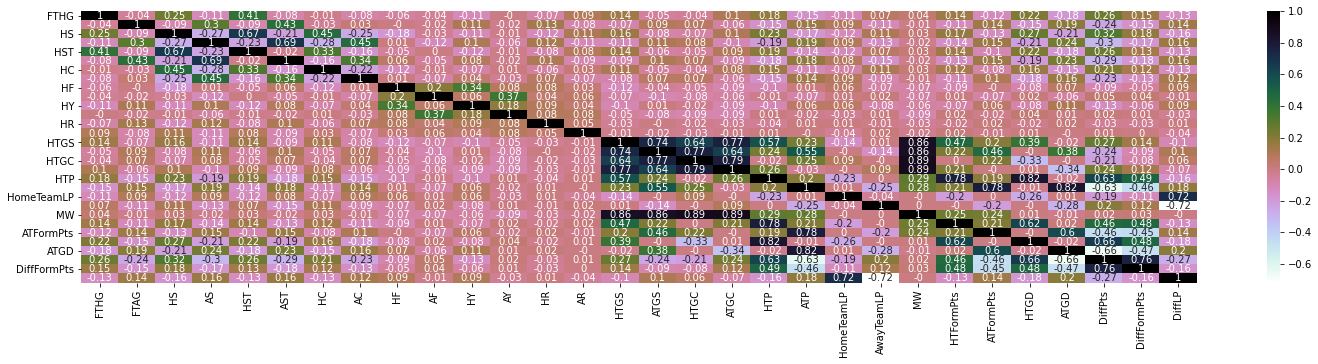

In [39]:
corr = playing_stat.corr().round(2)
plt.figure(figsize = (25,5))
map = heatmap(corr, annot = True, cmap = 'cubehelix_r')
plt.show()

In [40]:
#let's see if we've got missing values in our dataframe
playing_stat.isna().sum()

Date            0
HomeTeam        0
AwayTeam        0
FTHG            0
FTAG            0
FTR             0
HS              0
AS              0
HST             0
AST             0
HC              0
AC              0
HF              0
AF              0
HY              0
AY              0
HR              0
AR              0
HTGS            0
ATGS            0
HTGC            0
ATGC            0
HTP             0
ATP             0
HM1             0
AM1             0
HM2             0
AM2             0
HM3             0
AM3             0
HM4             0
AM4             0
HM5             0
AM5             0
HomeTeamLP      0
AwayTeamLP      0
MW              0
HTFormPtsStr    0
ATFormPtsStr    0
HTFormPts       0
ATFormPts       0
HTGD            0
ATGD            0
DiffPts         0
DiffFormPts     0
DiffLP          0
dtype: int64

In [41]:
playing_stat.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS',
       'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'HTGS',
       'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'AM1', 'HM2', 'AM2', 'HM3',
       'AM3', 'HM4', 'AM4', 'HM5', 'AM5', 'HomeTeamLP', 'AwayTeamLP', 'MW',
       'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTGD',
       'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP'],
      dtype='object')

#Preparing and Training the Logistic Regression model

Firstly, let's use *Label encoder* to handle categorical data.

In [42]:
playing_stat.shape

(7600, 46)

In [43]:
playing_stat.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,0.0
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,5.0,9.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,-4.0
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,14.0,12.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,2.0
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,16.0,15.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,1.0
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,3.0,13.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,-10.0


In [44]:
cols = ['HM1',	'AM1',	'HM2',	'AM2',	'HM3',	'AM3',	'HM4',	'AM4',	'HM5',	'AM5', 'FTR']
le = LabelEncoder()
df = playing_stat

for col in cols:
  df[col] = le.fit_transform(df[col])

df.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,19/08/00,Charlton,Man City,4,0,2,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,0.0,0.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,0.0
1,19/08/00,Chelsea,West Ham,4,2,2,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,5.0,9.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,-4.0
2,19/08/00,Coventry,Middlesbrough,1,3,0,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,14.0,12.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,2.0
3,19/08/00,Derby,Southampton,2,2,1,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,16.0,15.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,1.0
4,19/08/00,Leeds,Everton,2,0,2,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,3.0,13.0,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0,-10.0


In [45]:
scaler = StandardScaler()
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = ['HTGD','ATGD','HTP','ATP', 'DiffPts', 'DiffFormPts']

for col in cols:
    df[col] = scale(df[col])

In [46]:
# mean is 0 and variance is 1.
print('mean: ', round(np.mean(df['HTP']), 1), '\nvariance: ', round(np.var(df['HTP']), 1))

mean:  0.0 
variance:  1.0


In [47]:
df[:6030]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,19/08/00,Charlton,Man City,4,0,2,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,-2.331429,-2.374800,2,2,2,2,2,2,2,2,2,2,0.0,0.0,1.0,MMMMM,MMMMM,0,0,0.012552,-0.019656,0.021092,0.035927,0.0
1,19/08/00,Chelsea,West Ham,4,2,2,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,-2.331429,-2.374800,2,2,2,2,2,2,2,2,2,2,5.0,9.0,1.0,MMMMM,MMMMM,0,0,0.012552,-0.019656,0.021092,0.035927,-4.0
2,19/08/00,Coventry,Middlesbrough,1,3,0,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,-2.331429,-2.374800,2,2,2,2,2,2,2,2,2,2,14.0,12.0,1.0,MMMMM,MMMMM,0,0,0.012552,-0.019656,0.021092,0.035927,2.0
3,19/08/00,Derby,Southampton,2,2,1,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,-2.331429,-2.374800,2,2,2,2,2,2,2,2,2,2,16.0,15.0,1.0,MMMMM,MMMMM,0,0,0.012552,-0.019656,0.021092,0.035927,1.0
4,19/08/00,Leeds,Everton,2,0,2,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,-2.331429,-2.374800,2,2,2,2,2,2,2,2,2,2,3.0,13.0,1.0,MMMMM,MMMMM,0,0,0.012552,-0.019656,0.021092,0.035927,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025,16/04/2016,Everton,Southampton,1,1,1,7,18,2,4,3,10,8,14,1,1,0,0,52,41,43,33,0.007956,0.393637,0,1,0,3,1,3,1,0,1,1,12.0,11.0,33.0,DDLLL,LWWDL,2,7,0.424069,0.347527,-0.304677,-0.342909,1.0
6026,16/04/2016,Man United,Aston Villa,1,0,2,13,7,4,1,14,3,9,10,0,1,0,0,39,22,30,62,0.768256,-1.432353,1,1,3,1,3,1,1,1,3,1,3.0,17.0,33.0,LWWLW,LLLLL,9,0,0.424069,-1.855568,1.743016,0.717833,-14.0
6027,16/04/2016,Newcastle,Swansea,3,0,2,12,11,7,1,3,7,13,9,2,1,0,0,32,33,61,42,-0.869313,-0.195392,1,0,1,3,0,1,1,3,1,3,13.0,0.0,33.0,LLDLL,DWLWW,1,10,-1.313448,-0.432736,-0.537370,-0.645978,13.0
6028,16/04/2016,Norwich,Sunderland,0,3,0,19,8,6,3,14,0,7,11,2,2,0,0,35,36,56,57,-0.518406,-0.784421,3,1,3,0,0,0,1,0,1,0,20.0,0.0,33.0,WWDLL,LDDDD,7,4,-0.947655,-0.983510,0.207246,0.263229,20.0


In [48]:
# getting from season 2016/2017 for testing and before this season for training
x = df[6030:]

x_train = df[:6030]
x_test = x

y_train = x_train['FTR'] 
y_test = x_test['FTR']

x_train = df[:6030].drop(columns = ['HTFormPtsStr',	'ATFormPtsStr', 'Date',	'HomeTeam',	'AwayTeam', 'FTR', 'FTHG',	'FTAG', 'MW'])
x_test = x.drop(columns = ['HTFormPtsStr',	'ATFormPtsStr', 'Date',	'HomeTeam',	'AwayTeam', 'FTR', 'FTHG',	'FTAG', 'MW'])

In [49]:
x_train.sample(5)

,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,HomeTeamLP,AwayTeamLP,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
2957,12,13,4,7,3,8,8,12,2,2,0,0,33,30,45,56,-0.658769,-0.560590,1,1,3,1,0,1,0,1,0,0,0.0,13.0,6,1,-0.591007,-1.332333,-0.081293,0.452648,-13.0
1974,14,5,5,4,4,2,16,10,1,0,0,0,7,1,6,9,0.322311,-1.645876,1,1,1,1,0,1,3,1,3,1,8.0,4.0,7,0,0.201164,-1.534283,1.556862,2.223708,4.0
3989,7,15,5,9,3,4,16,11,1,0,1,0,15,37,29,20,-0.401436,1.205878,3,3,0,1,0,3,1,3,1,1,16.0,3.0,5,9,-1.099266,1.335538,-1.272188,-0.490456,13.0
5937,25,6,6,2,5,5,9,11,3,0,0,1,36,18,28,38,0.563560,-1.321910,0,0,1,0,3,3,3,1,3,1,16.0,17.0,10,5,0.515518,-1.281845,1.492872,0.556828,-1.0
1923,20,8,14,3,6,7,16,11,5,2,0,0,2,1,1,2,-0.401436,-1.726868,1,1,3,0,2,2,2,2,2,2,2.0,13.0,3,1,0.515518,-0.524532,1.044939,1.702808,-11.0


In [50]:
print(
    ' x_train: ', x_train.shape, '\n',
    'x_test: ', x_test.shape, '\n',
    'y_train: ', y_train.shape,'\n',
    'y_test: ', y_test.shape)

 x_train:  (6030, 37) 
 x_test:  (1570, 37) 
 y_train:  (6030,) 
 y_test:  (1570,)


##Not penalizing the model

In [51]:
log_reg_no = LogisticRegression(random_state = 42, solver='newton-cg').fit(x_train, y_train)
log_reg_coefs = log_reg_no.coef_[0]
log_reg_coefs

array([ 0.04806274, -0.03686129, -0.15600347,  0.19496156,  0.0502342 ,
       -0.07839337, -0.01571629,  0.00572781,  0.09176   , -0.07351637,
        0.6830621 , -0.46468084, -0.00367479,  0.00138262,  0.00558174,
       -0.00528956, -0.0961324 ,  0.07651078, -0.00569384,  0.1300719 ,
        0.03735839, -0.04893854,  0.02462625, -0.01159186,  0.03486125,
       -0.01721878,  0.0599482 , -0.01903265,  0.00295538, -0.00434644,
       -0.05228643,  0.04807408, -0.0735147 ,  0.06977019, -0.13694654,
        0.22355974,  0.00730182])

In [52]:
# test error not penalizing the model
y_pred_no = log_reg_no.predict_proba(x_test)
log_loss(y_test, y_pred_no) 

0.8815110286012089

In [53]:
# accuracy on train
y_pred_treino = log_reg_no.predict(x_train)
accuracy_score(y_train, y_pred_treino)

0.5903814262023217

In [54]:
# accuracy on test
y_pred_test = log_reg_no.predict(x_test)
accuracy_score(y_test, y_pred_test)

0.5828025477707006

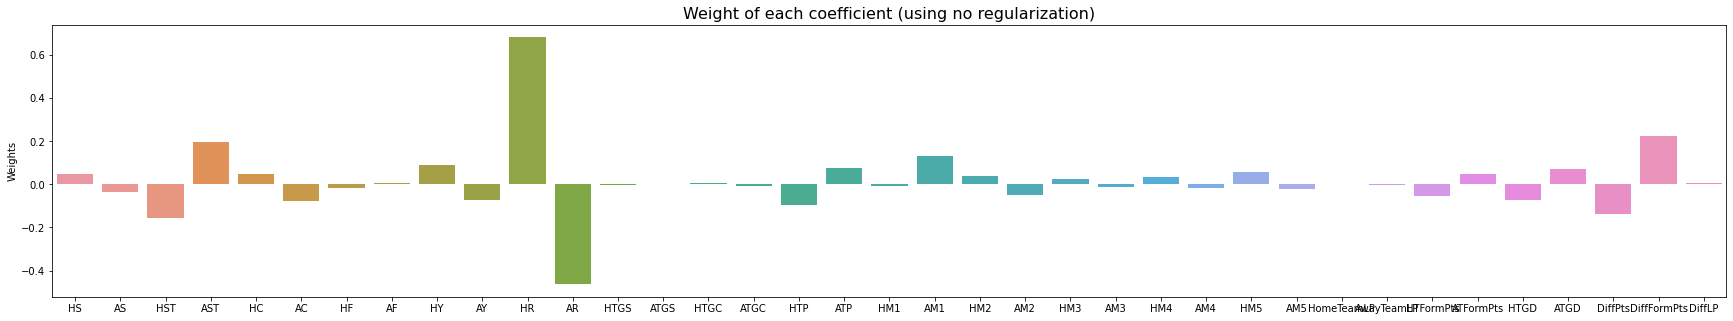

In [55]:
plt.figure(figsize = (30, 5))
sns.barplot(x = x_train.columns, y = log_reg_coefs)
plt.title("Weight of each coefficient (using no regularization)", fontdict = {'size': 16})
plt.ylabel("Weights")
plt.show()


##Penalizing the model

###Finding the best hyperparameter

In [59]:
log_reg = LogisticRegression(random_state = 42, max_iter = 1000)

# defining the search space
space = dict()
space['solver'] = ['lbfgs', 'newton-cg', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = np.arange(10**-4, 20, 0.01)

# training the model and fitting our data to it
rscv = RandomizedSearchCV(log_reg, space, cv = 3, n_jobs = -1, n_iter = 100)
result = rscv.fit(x_train, y_train)

In [60]:
#best C and regularization
C = rscv.best_params_
c = C['C']
l_penalty = C['penalty']

#printing c (best hyperparameter) and penalty
print("C: ", c, "\nPenalty: ", l_penalty)

C:  0.9201 
Penalty:  l2


###Training and Predicting using the best hyperparameter found above

In [61]:
logistic_reg = LogisticRegression(penalty = l_penalty, C = c, random_state = 42, max_iter = 1000)
logistic_reg.fit(x_train, y_train)

LogisticRegression(C=0.9201, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
# coefficients of our logistic regression model (notice that some were pushed to zero)
log_reg_coefs = logistic_reg.coef_[0]
log_reg_coefs

array([ 0.04792668, -0.03694194, -0.15596263,  0.19489287,  0.05010224,
       -0.07844528, -0.01580691,  0.00561851,  0.09167381, -0.07344648,
        0.68025712, -0.46312875, -0.0037588 ,  0.00142304,  0.00566209,
       -0.00537203, -0.09515016,  0.07683389, -0.00613987,  0.1301615 ,
        0.03690783, -0.04880377,  0.0242055 , -0.01163228,  0.0345323 ,
       -0.01717885,  0.05953482, -0.0190004 ,  0.00291295, -0.00439207,
       -0.0521744 ,  0.04770064, -0.07270444,  0.06917395, -0.13642021,
        0.22282767,  0.00730502])

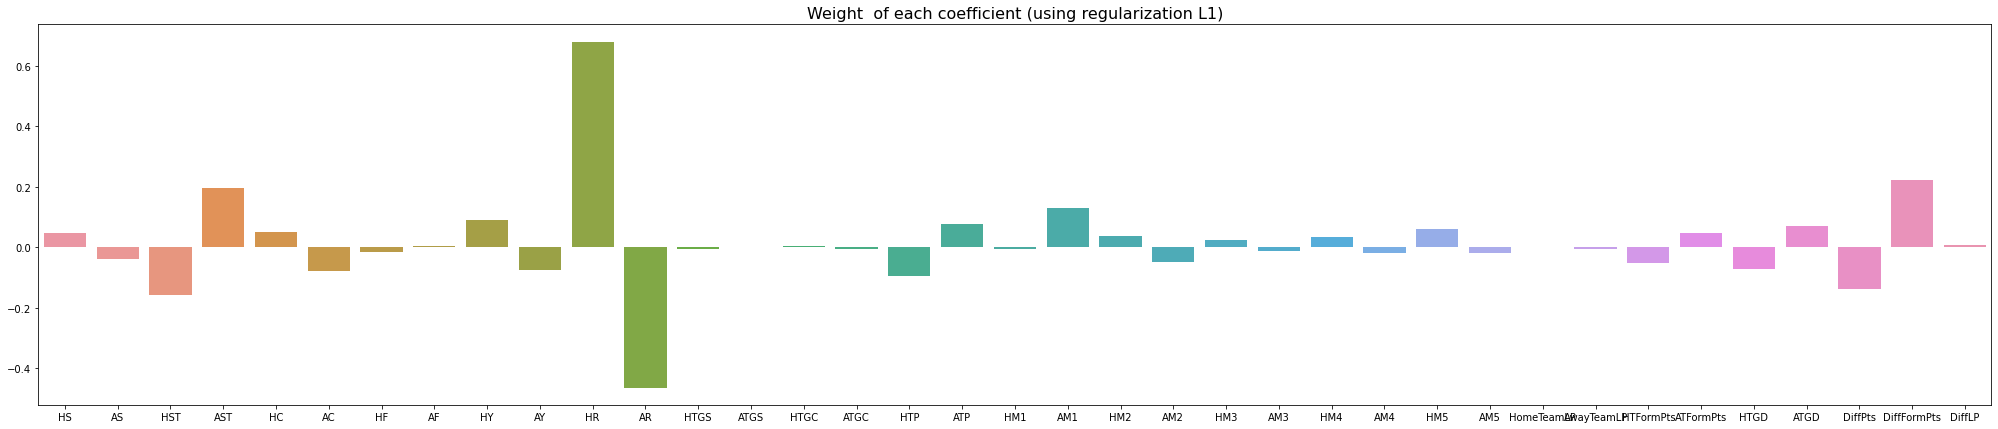

In [63]:
plt.figure(figsize = (35, 7))
sns.barplot(x = x_train.columns, y = log_reg_coefs)
plt.title("Weight  of each coefficient (using regularization L1)", fontdict = {'size': 16})
plt.show()

In [72]:
y_pred = logistic_reg.predict(x_test)

#predicted values from test
inv = le.inverse_transform(y_pred)
inv, y_pred

(array(['H', 'A', 'H', ..., 'A', 'A', 'H'], dtype=object),
 array([2, 0, 2, ..., 0, 0, 2]))

In [65]:
y_proba = logistic_reg.predict_proba(x_test)
y_proba_train = logistic_reg.predict_proba(x_train)
y_proba[:, 1]

array([0.35680204, 0.18194377, 0.38540239, ..., 0.22045068, 0.39575172,
       0.2792769 ])

In [66]:
# train error
print("Train error: ", log_loss(y_train, y_proba_train))

Train error:  0.8899752384040814


In [67]:
# test error
print("Test error: ", log_loss(y_test, y_proba))

Test error:  0.8813976123576683


##Evaluating our results

To evaluate our model, let's use a confusion matrix and get important metrics from it.

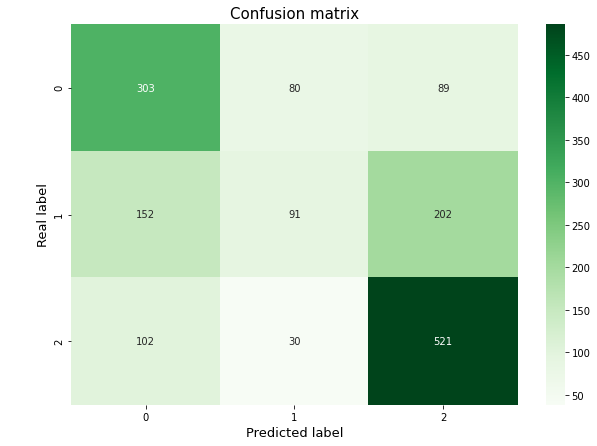

In [68]:
# Confusion matrix
plt.figure(figsize = (10, 7))
c_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1, 2])
sns.heatmap(c_matrix, annot = True, cmap =  'Greens', robust = True, fmt = '.3g')
plt.title("Confusion matrix", size = 15)
plt.ylabel("\n\nReal label", size = 13)
plt.xlabel("Predicted label", size = 13)
plt.show()


In [69]:
print('Confusion matrix: \n', c_matrix)

Confusion matrix: 
 [[303  80  89]
 [152  91 202]
 [102  30 521]]


In [70]:
print('Accuracy on test: ', accuracy_score(y_test, y_pred))

Accuracy on test:  0.5828025477707006


In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.64      0.59       472
           1       0.45      0.20      0.28       445
           2       0.64      0.80      0.71       653

    accuracy                           0.58      1570
   macro avg       0.55      0.55      0.53      1570
weighted avg       0.56      0.58      0.55      1570

